[Info] Seed fixed to 42
Device: cuda
Loading 10 subjects from /content/drive/MyDrive/Colab Notebooks/HAR_data/MHEALTHDATASET...

 >>> Starting LOSO with Cheating Test

[Fold 10/10] Testing on subject10 ...
[Info] Seed fixed to 42
  Ep 20 | Loss: 1133.9457
  Ep 40 | Loss: 102.5193
  Ep 60 | Loss: 39.8585
  Ep 80 | Loss: 10.3495
  Ep 100 | Loss: 4.7100

 >>> Running Length Cheating Test on subject10...

[Cheating Test] Original Count: 46.49, Length: 1024
  + Added 0 segments (0 frames) -> Pred: 46.49 (Delta: +0.00)
  + Added 2 segments (400 frames) -> Pred: 56.20 (Delta: +9.72)
  + Added 5 segments (1000 frames) -> Pred: 67.44 (Delta: +20.96)
  + Added 10 segments (2000 frames) -> Pred: 86.17 (Delta: +39.68)
  + Added 20 segments (4000 frames) -> Pred: 123.62 (Delta: +77.14)


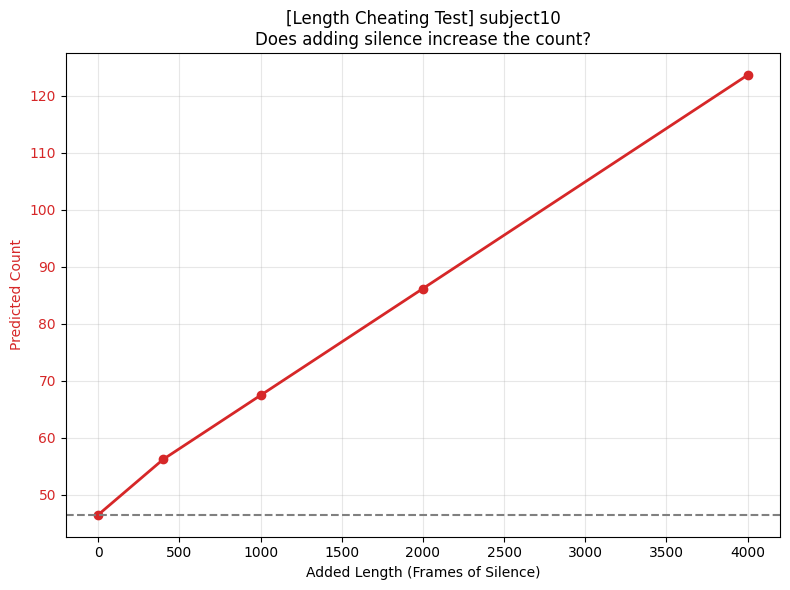

In [1]:
import os
import glob
import random
import numpy as np
import pandas as pd
from scipy.ndimage import gaussian_filter1d
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# ------------------------------------------------------------------------------
# 1. Strict Seeding
# ------------------------------------------------------------------------------
def set_strict_seed(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print(f"[Info] Seed fixed to {seed}")

# ------------------------------------------------------------------------------
# 2. Data Loading
# ------------------------------------------------------------------------------
def load_mhealth_dataset(data_dir, target_activities_map, column_names):
    full_dataset = {}
    file_list = sorted(glob.glob(os.path.join(data_dir, "mHealth_subject*.log")))

    if not file_list:
        print(f"[Warning] No mHealth logs found in {data_dir}")
        return {}

    print(f"Loading {len(file_list)} subjects from {data_dir}...")

    for file_path in file_list:
        file_name = os.path.basename(file_path)
        subj_part = file_name.split('.')[0]
        try:
            subj_id_num = int(''.join(filter(str.isdigit, subj_part)))
            subj_key = f"subject{subj_id_num}"
        except:
            subj_key = subj_part

        try:
            df = pd.read_csv(file_path, sep="\t", header=None)
            df = df.iloc[:, :len(column_names)]
            df.columns = column_names

            subj_data = {}
            for label_code, activity_name in target_activities_map.items():
                activity_df = df[df['activity_id'] == label_code].copy()
                if not activity_df.empty:
                    subj_data[activity_name] = activity_df.drop(columns=['activity_id'])

            full_dataset[subj_key] = subj_data
        except Exception as e:
            print(f"Error loading {file_name}: {e}")
            pass

    return full_dataset

def prepare_trial_list(label_config, full_data, target_map, feature_map):
    trial_list = []
    for subj, act_id, gt_count in label_config:
        act_name = target_map.get(act_id)
        feats = feature_map.get(act_id)

        if subj in full_data and act_name in full_data[subj]:
            # Get raw data (N, C)
            raw_df = full_data[subj][act_name][feats]
            raw_np = raw_df.values.astype(np.float32)

            # Instance-wise Normalization (중요: Cheating Test 시에도 동일 적용됨)
            mean = raw_np.mean(axis=0)
            std = raw_np.std(axis=0) + 1e-6
            norm_np = (raw_np - mean) / std

            trial_list.append({
                'data': norm_np,
                'count': float(gt_count),
                'meta': f"{subj}_{act_name}"
            })
        else:
            print(f"[Skip] Missing data for {subj} - {act_name}")

    return trial_list

# ------------------------------------------------------------------------------
# 3. Model Classes (Baseline Count Model)
# ------------------------------------------------------------------------------
class ManifoldEncoder(nn.Module):
    def __init__(self, input_ch, hidden_dim=128, latent_dim=16):
        super().__init__()
        # Kernel 31 (Phase 3와 통일)
        self.net = nn.Sequential(
            nn.Conv1d(input_ch, hidden_dim, kernel_size=31, padding=15),
            nn.GELU(),
            nn.Conv1d(hidden_dim, hidden_dim, kernel_size=31, padding=15),
            nn.GELU(),
            nn.Conv1d(hidden_dim, latent_dim, 1)
        )

    def forward(self, x):
        z = self.net(x)
        z = z.transpose(1, 2)
        return z

class ManifoldDecoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv1d(latent_dim, hidden_dim, kernel_size=31, padding=15),
            nn.GELU(),
            nn.Conv1d(hidden_dim, hidden_dim, kernel_size=31, padding=15),
            nn.GELU(),
            nn.Conv1d(hidden_dim, out_ch, 1)
        )

    def forward(self, z):
        return self.net(z.transpose(1, 2))

class EventnessHead(nn.Module):
    def __init__(self, latent_dim=16, hidden=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(latent_dim, hidden),
            nn.GELU(),
            nn.Linear(hidden, 1)
        )
        # 초기 확률 낮게 설정 (-5.0)
        nn.init.constant_(self.net[-1].bias, -5.0)

    def forward(self, z):
        return self.net(z).squeeze(-1)

class CountModel(nn.Module):
    def __init__(self, input_ch, hidden_dim=128, latent_dim=16):
        super().__init__()
        self.encoder = ManifoldEncoder(input_ch, hidden_dim, latent_dim)
        self.decoder = ManifoldDecoder(latent_dim, hidden_dim, input_ch)
        self.event_head = EventnessHead(latent_dim, hidden_dim)
        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv1d) or isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
        nn.init.constant_(self.event_head.net[-1].bias, -5.0)

    def forward(self, x, mask=None):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        logits = self.event_head(z)
        eventness = torch.sigmoid(logits)

        if mask is not None:
            mask = mask.to(dtype=eventness.dtype, device=eventness.device)
            eventness = eventness * mask

        count_hat = eventness.sum(dim=1)
        return count_hat, eventness, z, x_hat

# ------------------------------------------------------------------------------
# 4. Cheating Test Helper Functions (Added)
# ------------------------------------------------------------------------------
def get_eventness_and_count(model, x_np, device, use_mask=True):
    """
    x_np: (T, C) numpy
    return: pred_count(float), prob_np(T,)
    """
    model.eval()
    x = torch.tensor(x_np, dtype=torch.float32).transpose(0,1).unsqueeze(0).to(device)  # (1,C,T)

    if use_mask:
        mask = torch.ones(1, x.shape[-1], device=device)
        with torch.no_grad():
            # 모델 리턴값 순서 주의: count_hat, eventness, z, x_hat
            pred_count, eventness, z, _ = model(x, mask=mask)
    else:
        with torch.no_grad():
            pred_count, eventness, z, _ = model(x, mask=None)

    return float(pred_count.item()), eventness[0].detach().cpu().numpy()

def find_low_energy_segment(x_np, seg_len=250, smooth=25):
    """
    저에너지 구간(움직임 거의 없는) seg_len 프레임을 찾아 반환
    """
    energy = np.linalg.norm(x_np, axis=1) # (T,)
    energy_s = gaussian_filter1d(energy, sigma=smooth)

    T = len(energy_s)
    if T <= seg_len:
        # 데이터가 너무 짧으면 그냥 0으로 채워진 더미 반환 (혹은 원본)
        return np.zeros((seg_len, x_np.shape[1]), dtype=x_np.dtype), 0

    csum = np.cumsum(np.r_[0.0, energy_s])
    # Sliding window mean
    win_mean = (csum[seg_len:] - csum[:-seg_len]) / seg_len
    idx = int(np.argmin(win_mean))
    return x_np[idx:idx+seg_len].copy(), idx

def length_cheating_test(model, x_np, device, seg_len=250, repeats_list=(0, 2, 5, 10), use_mask=True):
    # 1. Base prediction
    base_count, base_prob = get_eventness_and_count(model, x_np, device, use_mask=use_mask)

    # 2. Find quiet segment
    seg, idx0 = find_low_energy_segment(x_np, seg_len=seg_len)

    results = []
    print(f"\n[Cheating Test] Original Count: {base_count:.2f}, Length: {x_np.shape[0]}")

    for r in repeats_list:
        if r == 0:
            x_aug = x_np
        else:
            # 3. Augment: Quiet segment를 r번 반복해서 뒤에 붙임 (혹은 중간에)
            # 여기서는 간단히 뒤에 붙입니다.
            extra = np.tile(seg, (r, 1))  # (r*seg_len, C)
            x_aug = np.concatenate([x_np, extra], axis=0)

        pred_count, prob = get_eventness_and_count(model, x_aug, device, use_mask=use_mask)

        delta = pred_count - base_count

        results.append({
            "repeat": r,
            "added_len": r * seg_len,
            "total_len": x_aug.shape[0],
            "pred_count": pred_count,
            "delta": delta,
            "mean_p": float(prob.mean()),
        })
        print(f"  + Added {r} segments ({r*seg_len} frames) -> Pred: {pred_count:.2f} (Delta: {delta:+.2f})")

    return results

def visualize_cheating_results(results, subject_name):
    added_lens = [r['added_len'] for r in results]
    preds = [r['pred_count'] for r in results]
    deltas = [r['delta'] for r in results]

    fig, ax1 = plt.subplots(figsize=(8, 6))

    color = 'tab:red'
    ax1.set_xlabel('Added Length (Frames of Silence)')
    ax1.set_ylabel('Predicted Count', color=color)
    ax1.plot(added_lens, preds, marker='o', linestyle='-', color=color, linewidth=2, label='Pred Count')
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.grid(True, alpha=0.3)

    # Reference Line (Flat)
    ax1.axhline(y=preds[0], color='gray', linestyle='--', label='Original Count')

    plt.title(f"[Length Cheating Test] {subject_name}\nDoes adding silence increase the count?")
    fig.tight_layout()
    plt.show()

# ------------------------------------------------------------------------------
# 5. Training & Utils
# ------------------------------------------------------------------------------
class TrialDataset(Dataset):
    def __init__(self, trial_list):
        self.trials = trial_list
    def __len__(self):
        return len(self.trials)
    def __getitem__(self, idx):
        item = self.trials[idx]
        data = torch.tensor(item['data'], dtype=torch.float32).transpose(0, 1)
        count = torch.tensor(item['count'], dtype=torch.float32)
        return data, count, item['meta']

def collate_variable_length(batch):
    max_len = max([x[0].shape[1] for x in batch])
    C = batch[0][0].shape[0]
    padded_data, masks, counts, metas = [], [], [], []
    for data, count, meta in batch:
        T = data.shape[1]
        pad_size = max_len - T
        if pad_size > 0:
            pad = torch.zeros(C, pad_size)
            d_padded = torch.cat([data, pad], dim=1)
            mask = torch.cat([torch.ones(T), torch.zeros(pad_size)], dim=0)
        else:
            d_padded = data
            mask = torch.ones(T)
        padded_data.append(d_padded)
        masks.append(mask)
        counts.append(count)
        metas.append(meta)
    return {"data": torch.stack(padded_data), "mask": torch.stack(masks), "count": torch.stack(counts), "meta": metas}

def masked_recon_mse(x_hat, x, mask, eps=1e-6):
    mask = mask.to(dtype=x.dtype, device=x.device).unsqueeze(1)
    se = (x_hat - x) ** 2 * mask
    denom = (mask.sum() * x.shape[1]) + eps
    return se.sum() / denom

def train_one_epoch(model, loader, optimizer, config, device):
    model.train()
    total_loss = 0
    lambda_recon = config.get("lambda_recon", 1.0)
    for batch in loader:
        x = batch["data"].to(device)
        mask = batch["mask"].to(device)
        y_true = batch["count"].to(device)
        optimizer.zero_grad()
        pred_count, eventness, z, x_hat = model(x, mask)
        loss = (config["lambda_count"] * F.mse_loss(pred_count, y_true) +
                lambda_recon * masked_recon_mse(x_hat, x, mask) +
                config["lambda_sparse"] * eventness.mean() +
                config["lambda_tv"] * torch.mean(torch.abs(eventness[:, 1:] - eventness[:, :-1])))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

# ------------------------------------------------------------------------------
# 6. Main
# ------------------------------------------------------------------------------
def main():
    CONFIG = {
        "seed": 42,
        "data_dir": "/content/drive/MyDrive/Colab Notebooks/HAR_data/MHEALTHDATASET",
        "COLUMN_NAMES": [
            'acc_chest_x', 'acc_chest_y', 'acc_chest_z', 'ecg_1', 'ecg_2',
            'acc_ankle_x', 'acc_ankle_y', 'acc_ankle_z', 'gyro_ankle_x', 'gyro_ankle_y', 'gyro_ankle_z',
            'mag_ankle_x', 'mag_ankle_y', 'mag_ankle_z', 'acc_arm_x', 'acc_arm_y', 'acc_arm_z',
            'gyro_arm_x', 'gyro_arm_y', 'gyro_arm_z', 'mag_arm_x', 'mag_arm_y', 'mag_arm_z', 'activity_id'
        ],
        "TARGET_ACTIVITIES_MAP": {6: 'Waist bends', 7: 'Arms elevation', 8: 'Knees bending', 12: 'Jump front & back'},
        "ACT_FEATURE_MAP": {
            6: ['acc_chest_x', 'acc_chest_y', 'acc_chest_z', 'acc_arm_x', 'acc_arm_y', 'acc_arm_z'],
            7: ['acc_arm_x', 'acc_arm_y', 'acc_arm_z', 'gyro_arm_x', 'gyro_arm_y', 'gyro_arm_z'],
            8: ['acc_ankle_x', 'acc_ankle_y', 'acc_ankle_z', 'gyro_ankle_x', 'gyro_ankle_y', 'gyro_ankle_z'],
            12: ['acc_chest_x', 'acc_chest_y', 'acc_chest_z', 'acc_ankle_x', 'acc_ankle_y', 'acc_ankle_z']
        },
        "epochs": 100, # Cheating Test 확인용으로 충분
        "lr": 5e-4, "batch_size": 64,
        "lambda_count": 1.0, "lambda_recon": 1.0, "lambda_sparse": 0.01, "lambda_tv": 0.01,
        "hidden_dim": 128, "latent_dim": 16,
        "ALL_LABELS": [
            ("subject1", 12, 40), ("subject2", 12, 45), ("subject3", 12, 42), ("subject4", 12, 42),
            ("subject5", 12, 40), ("subject6", 12, 42), ("subject7", 12, 38), ("subject8", 12, 41),
            ("subject9", 12, 41), ("subject10", 12, 40),
        ]
    }

    set_strict_seed(CONFIG["seed"])
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Device: {device}")

    full_data = load_mhealth_dataset(CONFIG["data_dir"], CONFIG["TARGET_ACTIVITIES_MAP"], CONFIG["COLUMN_NAMES"])
    if not full_data: return

    # LOSO Loop
    num_subjects = len(CONFIG["ALL_LABELS"])
    print("\n" + "="*50 + "\n >>> Starting LOSO with Cheating Test\n" + "="*50)

    for i in range(num_subjects):
        test_label_cfg = [CONFIG["ALL_LABELS"][i]]
        train_label_cfg = CONFIG["ALL_LABELS"][:i] + CONFIG["ALL_LABELS"][i+1:]
        target_subject = test_label_cfg[0][0]

        # 데모를 위해 마지막 Subject 10에서만 멈춰서 Cheating Test 수행
        # (전부 다 하면 시간이 오래 걸리므로)
        if target_subject != "subject10":
            continue

        print(f"\n[Fold {i+1}/{num_subjects}] Testing on {target_subject} ...")
        set_strict_seed(CONFIG["seed"])

        train_data = prepare_trial_list(train_label_cfg, full_data, CONFIG["TARGET_ACTIVITIES_MAP"], CONFIG["ACT_FEATURE_MAP"])
        test_data = prepare_trial_list(test_label_cfg, full_data, CONFIG["TARGET_ACTIVITIES_MAP"], CONFIG["ACT_FEATURE_MAP"])

        train_loader = DataLoader(TrialDataset(train_data), batch_size=CONFIG["batch_size"], shuffle=True, collate_fn=collate_variable_length)

        input_ch = train_data[0]['data'].shape[1]
        model = CountModel(input_ch, CONFIG["hidden_dim"], CONFIG["latent_dim"]).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=CONFIG["lr"])
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)

        for epoch in range(CONFIG["epochs"]):
            loss = train_one_epoch(model, train_loader, optimizer, CONFIG, device)
            scheduler.step()
            if (epoch+1) % 20 == 0:
                print(f"  Ep {epoch+1} | Loss: {loss:.4f}")

        # --- Cheating Test 실행 ---
        print(f"\n >>> Running Length Cheating Test on {target_subject}...")
        # Test 데이터의 원본 numpy 데이터 가져오기 (정규화된 상태)
        x_sample = test_data[0]['data']

        # 조작 실험 수행 (0, 2, 5, 10, 20배 구간 반복 추가)
        results = length_cheating_test(model, x_sample, device, seg_len=200, repeats_list=[0, 2, 5, 10, 20])

        # 결과 시각화
        visualize_cheating_results(results, target_subject)

if __name__ == "__main__":
    main()